In [1]:
from google.colab import drive
drive.mount("/content/drive")
# @title Mount Drive

Mounted at /content/drive


In [2]:
%%capture
!pip install nilearn
!pip install hcp_utils
# @title Install Dependencies

In [6]:
import pandas as pd
import numpy as np
import glob
import os,sys
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import nibabel as nib
import hcp_utils as hcp
import scipy
from nilearn.connectome import sym_matrix_to_vec
# @title Importage

In [7]:
data_dir = '/content/drive/MyDrive/TORONTO/kcnischool_2022/ds000201/'

subj_info = data_dir + '/subjinfo/participants.tsv'
subj_info = pd.read_csv(subj_info,sep='\t',index_col=0)
subj_info.head()

,Sex,AgeGroup,BMI1,BMI2,EducationLevel,HADS_Anxiety,HADS_Depression,ISI,KSQ_SleepQualityIndex,KSQ_WakeupSymptomIndex,...,PPIR_IR15,PPIR_IR40,BADD_Total,BADD_Activation,BADD_Attention,BADD_Effort,BADD_Affect,BADD_Memory,Sl_cond,Trial
participant_id,,,,,,,,,,,,,,,,,,,,,
sub-9001,Male,Young,"19,78997095","19,78997095",Studerar för närvarande på universitet/högskola,0,1,12,"4,75","4,666666667",...,11.0,29.0,16.0,6.0,2.0,2.0,6.0,0.0,2,B
sub-9002,Male,Old,"21,79944511","21,46915048",Har avslutat gymnasieskolan,2,3,9,"5,5","5,666666667",...,10.0,32.0,33.0,5.0,8.0,6.0,8.0,6.0,2,B
sub-9003,Male,Old,"20,49861496","20,49861496",Har examen från universitet/högskola,2,3,10,"5,25","5,666666667",...,12.0,26.0,13.0,4.0,4.0,4.0,1.0,0.0,1,B
sub-9004,Female,Old,"22,94811574","22,94811574",Har examen från universitet/högskola,1,2,11,"4,25","5,666666667",...,10.0,28.0,24.0,3.0,7.0,5.0,6.0,3.0,1,B
sub-9005,Male,Old,"24,75546432","24,75546432",Har avslutat gymnasieskolan,0,0,9,6,"5,666666667",...,8.0,28.0,30.0,9.0,5.0,7.0,3.0,6.0,2,B


In [182]:
dwi_files = sorted(glob.glob(data_dir + '/dwiconn/*.csv'))
subj2use = []

for xx in range(len(dwi_files)):
  subj2use.append(dwi_files[xx][65:73])

subj_info_filtered = subj_info.loc[subj2use]
subj_info_filtered.head()

,Sex,AgeGroup,BMI1,BMI2,EducationLevel,HADS_Anxiety,HADS_Depression,ISI,KSQ_SleepQualityIndex,KSQ_WakeupSymptomIndex,...,PPIR_IR15,PPIR_IR40,BADD_Total,BADD_Activation,BADD_Attention,BADD_Effort,BADD_Affect,BADD_Memory,Sl_cond,Trial
participant_id,,,,,,,,,,,,,,,,,,,,,
sub-9002,Male,Old,"21,79944511","21,46915048",Har avslutat gymnasieskolan,2,3,9,"5,5","5,666666667",...,10.0,32.0,33.0,5.0,8.0,6.0,8.0,6.0,2,B
sub-9003,Male,Old,"20,49861496","20,49861496",Har examen från universitet/högskola,2,3,10,"5,25","5,666666667",...,12.0,26.0,13.0,4.0,4.0,4.0,1.0,0.0,1,B
sub-9004,Female,Old,"22,94811574","22,94811574",Har examen från universitet/högskola,1,2,11,"4,25","5,666666667",...,10.0,28.0,24.0,3.0,7.0,5.0,6.0,3.0,1,B
sub-9005,Male,Old,"24,75546432","24,75546432",Har avslutat gymnasieskolan,0,0,9,6,"5,666666667",...,8.0,28.0,30.0,9.0,5.0,7.0,3.0,6.0,2,B
sub-9008,Male,Old,"22,34029707","22,64219297",Har avslutat gymnasieskolan,1,1,9,5,4,...,13.0,28.0,17.0,4.0,5.0,3.0,1.0,4.0,2,A


In [9]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/'
atlas2use = 'Parcellations/MNI/Centroid_coordinates/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'

atlas  = pd.read_csv(url + atlas2use)
atlas

,ROI Label,ROI Name,R,A,S
0,1,7Networks_LH_Vis_1,-26,-34,-18
1,2,7Networks_LH_Vis_2,-26,-76,-14
2,3,7Networks_LH_Vis_3,-18,-60,-6
3,4,7Networks_LH_Vis_4,-26,-96,-4
4,5,7Networks_LH_Vis_5,-6,-92,-2
...,...,...,...,...,...
95,96,7Networks_RH_Default_PFCdPFCm_1,6,48,0
96,97,7Networks_RH_Default_PFCdPFCm_2,12,50,40
97,98,7Networks_RH_Default_PFCdPFCm_3,26,24,50
98,99,7Networks_RH_Default_pCunPCC_1,12,-54,14


In [545]:
coordinates = {'R': atlas['R'], 'A': atlas['A'], 'S': atlas['S']}
coordinates = pd.DataFrame(coordinates)
coordinates.head()

,R,A,S
0,-26,-34,-18
1,-26,-76,-14
2,-18,-60,-6
3,-26,-96,-4
4,-6,-92,-2


In [520]:
pts_dir = data_dir + '/ptseries/'
ses2use = 'ses-1'


all_ptsrs_fs = []

for xx in subj2use:
  all_ptsrs_fs.append(pts_dir + xx + '_' + ses2use + '_task-rest_atlas-SchaeferP100N7_desc-cleaneds0_bold.ptseries.nii')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':


[]

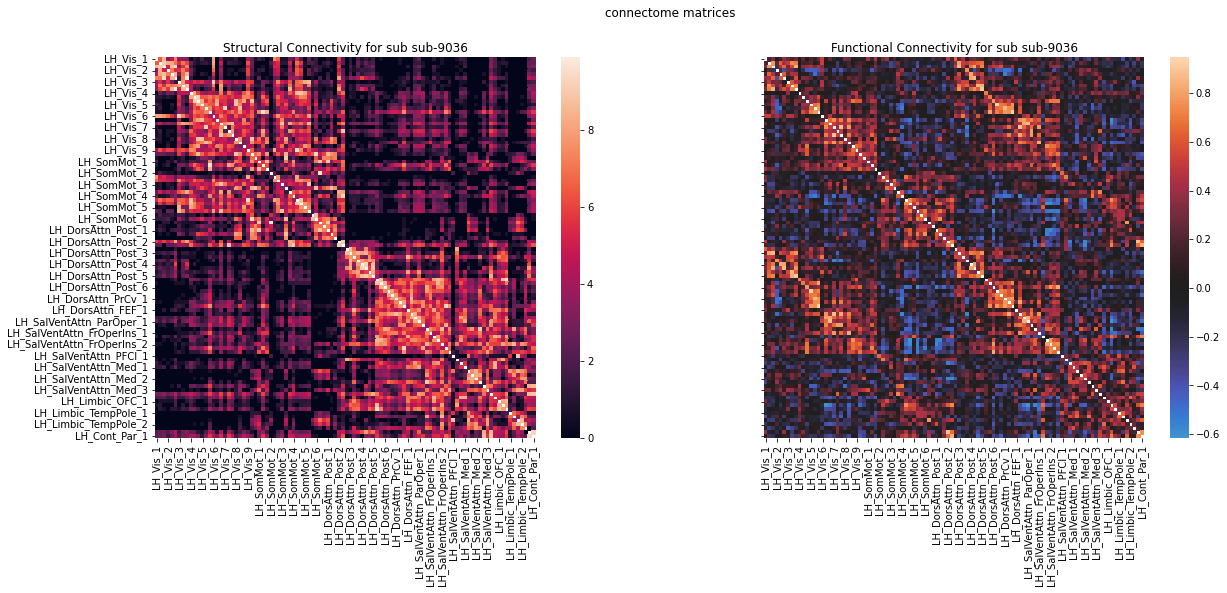

In [523]:
# @title #Plot SC and FC

sub = subj2use[8]
# Select Subject
sub = "sub-9036"  # @param ['sub-9002','sub-9003','sub-9004','sub-9005','sub-9008','sub-9009','sub-9011','sub-9014','sub-9018','sub-9020','sub-9023','sub-9025','sub-9026','sub-9028','sub-9029','sub-9032','sub-9033','sub-9034','sub-9036','sub-9038','sub-9039','sub-9040','sub-9041','sub-9042','sub-9045','sub-9046','sub-9047','sub-9048','sub-9049', 'sub-9055','sub-9058','sub-9061','sub-9062','sub-9064','sub-9065','sub-9068','sub-9069','sub-9071','sub-9072','sub-9075', 'sub-9079','sub-9080','sub-9081','sub-9084','sub-9085','sub-9086','sub-9087','sub-9088','sub-9089','sub-9092','sub-9093','sub-9094','sub-9096','sub-9098']

subj_idx = [i for i, s in enumerate(all_ptsrs_fs) if sub in s][0]

ts2use = nib.load(all_ptsrs_fs[subj_idx]).get_data()
fc_matrix = np.array(pd.DataFrame(ts2use).corr())
sc_matrix = np.array(pd.read_csv(data_dir + '/dwiconn/' + sub + '_Schaefer2018_100Parcels_7Networks.csv', sep = ' ' , header=None))
sc_matrix = sc_matrix -2*np.diag(np.diag(sc_matrix)) + sc_matrix.T 
sc_matrix =  np.log1p(sc_matrix)

label_stripped = []
for xx in range(len(atlas['ROI Name'])):
    label_stripped.append(atlas['ROI Name'][xx].replace('7Networks_',''))


#sns.heatmap(fc_matrix,center=0,mask=np.eye(100),)


fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle('connectome matrices')

# SC
sns.heatmap(sc_matrix,mask=np.eye(100), ax=axes.flat[0], square=True)
axes.flat[0].set_title('Structural Connectivity for sub ' + sub)
axes.flat[0].set_xticklabels(label_stripped, rotation=90)
axes.flat[0].set_yticklabels(label_stripped, rotation=0)

# FC (normalized between 0 and 3)
sns.heatmap(fc_matrix, center=0,mask=np.eye(100), ax=axes.flat[1], square=True)
axes.flat[1].set_title('Functional Connectivity for sub ' + sub)
axes.flat[1].set_xticklabels(label_stripped, rotation=90)
axes.flat[1].set_yticklabels(label_stripped, rotation=0)

Text(0.5, 1.0, 'r = 0.30852615502737674')

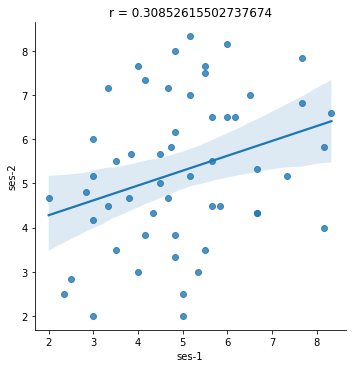

In [526]:
subj2use.remove("sub-9100")

KSS_mean_ses1 = []
KSS_mean_ses2 = []

for sub in subj2use:
  f = data_dir + '/subjinfo/%s_sessions.tsv' %sub
  _df = pd.read_csv(f,sep='\t',index_col=0).T
  KSS_mean_ses1.append(np.mean(_df['ses-1'][1:7][:]))
  KSS_mean_ses2.append(np.mean(_df['ses-2'][1:7][:]))

KSS_mean_ses1 = np.array(KSS_mean_ses1)
KSS_mean_ses2 = np.array(KSS_mean_ses2)


KSS_df = {'ses-1': KSS_mean_ses1, 'ses-2': KSS_mean_ses2}
KSS_df = pd.DataFrame(data=KSS_df)

sns.lmplot(x='ses-1', y='ses-2', data=KSS_df)
plt.title('r = ' + str(np.corrcoef(KSS_mean_ses1, KSS_mean_ses2)[0][1]))

In [519]:
if ses2use=='ses-1':
  Group = KSS_mean_ses1 > np.median(KSS_mean_ses1)
  Group = np.multiply(Group, 1)
  sleepy_idx = np.where(Group==1)[0]
  not_sleepy_idx = np.where(Group==0)[0]
elif ses2use=='ses-2':
  Group = KSS_mean_ses2 > np.median(KSS_mean_ses2)
  Group = np.multiply(Group, 1)
  sleepy_idx = np.where(Group==1)[0]
  not_sleepy_idx = np.where(Group==0)[0]

In [411]:
sleepy = np.zeros((len(sleepy_idx), 100, 100))
for xx in range(len(sleepy_idx)):               
  sub = subj2use[sleepy_idx[xx]]

  subj_idx = [i for i, s in enumerate(all_ptsrs_fs) if sub in s][0]

  ts2use = nib.load(all_ptsrs_fs[subj_idx]).get_data()
  sleepy[xx,:,:] = np.array(pd.DataFrame(ts2use).corr())

not_sleepy = np.zeros((len(not_sleepy_idx), 100, 100))
for xx in range(len(not_sleepy_idx)):               
  sub = subj2use[not_sleepy_idx[xx]]

  subj_idx = [i for i, s in enumerate(all_ptsrs_fs) if sub in s][0]

  ts2use = nib.load(all_ptsrs_fs[subj_idx]).get_data()
  not_sleepy[xx,:,:] = np.array(pd.DataFrame(ts2use).corr())



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


In [40]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def refresh(window=3):
    plt.imshow(not_sleepy[int(window)], interpolation="none", cmap="bwr", vmin=-1, vmax=1)
    plt.title('not sleepy')
    plt.show(sns)



style = {'description_width': 'initial'}

_ = widgets.interact(refresh, 
    window=widgets.FloatSlider(value=2, min=0, max=not_sleepy.shape[0], step=1, description="subj", style=style),
)  
  

interactive(children=(FloatSlider(value=2.0, description='subj', max=28.0, step=1.0, style=SliderStyle(descrip…

In [412]:
t_stat, p_val = scipy.stats.ttest_ind(not_sleepy, sleepy, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)


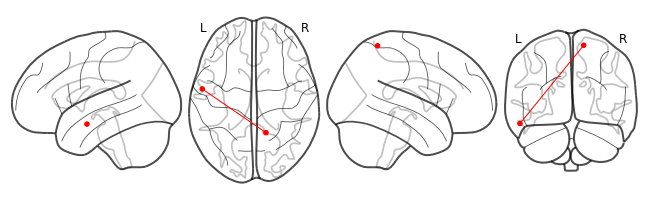

In [534]:
p_level = 0.0005
thresh = 1 - p_level
mat2plot = 1-p_val
mat2plot = mat2plot[np.triu_indices_from(p_val, k=1)]

mat2plot[mat2plot<=thresh] = 0
edge_frac = mat2plot/mat2plot.shape[0]
edge_frac_square = scipy.spatial.distance.squareform(edge_frac)*5000

node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
node_size = edge_frac_square.sum(axis=0)*node_mask*20 # size nodes based on how many suprathreshold edges they have
node_size = node_size

plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                node_color = 'red',
                node_coords=coordinates, node_size=node_size,
                display_mode= 'lzry',
                edge_kwargs={"linewidth": 1, 'color': 'red'})

In [535]:
thr = 0.0005
conn2exp = 0
print(atlas['ROI Name'][np.where(p_val<thr)[0][conn2exp]])
print(atlas['ROI Name'][np.where(p_val<thr)[1][conn2exp]])




7Networks_LH_Default_Temp_1
7Networks_RH_DorsAttn_Post_5


## Regression

In [268]:
from nilearn.plotting import plot_connectome

def mk_kfold_indices(subj_list, k = 10):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)


def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)


def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)


def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict



def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict


def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
        X = test_vcts.loc[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred


def cpm_wrapper(all_fc_data, all_behav_data, behav, k=10, **cpm_kwargs):

    #assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k=k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        print("doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        model_dict = build_model(train_vcts, mask_dict, train_behav)
        behav_pred = apply_model(test_vcts, mask_dict, model_dict)
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    return behav_obs_pred, all_masks


def plot_consistent_edges(all_masks, tail, thresh = 1., color='gray'):
    
    edge_frac = (all_masks[tail].sum(axis=0))/(all_masks[tail].shape[0])
    print("For the {} tail, {} edges were selected in at least {}% of folds".format(tail, (edge_frac>=thresh).sum(), thresh*100))
    edge_frac_square = scipy.spatial.distance.squareform(edge_frac)

    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0)*node_mask*20 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,
                    node_coords=coordinates, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})
    
#@title defining func for regression

In [550]:
var2regress = 'continous' # continous or dichotomy

if var2regress == 'continous':
  fc = np.concatenate((sleepy, not_sleepy))

  all_fc_data = np.zeros(((len(subj2use)), int(( len(atlas['ROI Name']) * (len(atlas['ROI Name']) - 1) ) / 2) )) #'n_nodes*(n_nodes-1)/2 


  prova = sym_matrix_to_vec(fc[0], discard_diagonal=True)
  for subject in range(fc.shape[0]):
      all_fc_data[subject,:] = fc[subject][np.triu_indices_from(fc[subject], k=1)]

  all_fc_data = pd.DataFrame(data=all_fc_data, index=subj2use)


elif var2regress == 'dichotomy':

  miss_value_idx = np.where(subj_info_filtered['SleepDeprivedSession1'].astype(str) == 'nan')[0]
  subj_info_filtered_removed = subj_info_filtered.drop(['sub-9100'], axis=0)


  for xx in miss_value_idx:
    subj_info_filtered_removed = subj_info_filtered_removed.drop([subj2use[xx]], axis=0)


  fc= np.zeros((len(subj2use), 100, 100))
  for xx in range(len(subj2use)):
    sub = subj2use[xx]
    subj_idx = [i for i, s in enumerate(all_ptsrs_fs) if sub in s][0]
    ts2use = nib.load(all_ptsrs_fs[subj_idx]).get_data()
    fc[xx,:,:] = np.array(pd.DataFrame(ts2use).corr())

  all_fc_data = np.zeros(((len(subj2use)), int(( len(atlas['ROI Name']) * (len(atlas['ROI Name']) - 1) ) / 2) )) #'n_nodes*(n_nodes-1)/2 


  prova = sym_matrix_to_vec(fc[0], discard_diagonal=True)
  for subject in range(fc.shape[0]):
      all_fc_data[subject,:] = fc[subject][np.triu_indices_from(fc[subject], k=1)]

  all_fc_data = pd.DataFrame(data=all_fc_data, index=subj2use)

  for xx in miss_value_idx:
    all_fc_data = all_fc_data.drop([subj2use[xx]], axis=0)



all_fc_data.head() 

,0,1,2,3,4,5,6,7,8,9,...,4940,4941,4942,4943,4944,4945,4946,4947,4948,4949
sub-9002,-0.268541,0.066754,-0.002081,-0.473618,0.029631,-0.073880,-0.197855,0.006655,0.354120,0.297336,...,0.700363,0.370715,0.671309,0.684687,0.500080,0.403040,0.668268,0.393627,0.724631,0.680627
sub-9003,-0.138797,0.237953,-0.277408,0.236070,0.257885,0.003697,-0.195221,-0.045329,0.030099,0.166123,...,0.493041,0.216672,0.539110,0.770461,-0.111735,0.148762,0.517436,0.456919,0.311614,0.659632
sub-9004,-0.320190,-0.031859,-0.205055,0.055709,0.548586,0.303540,-0.126600,0.315456,0.053672,0.076178,...,0.417258,-0.138106,0.412602,0.703702,0.241610,0.040340,0.478144,-0.022711,-0.120179,0.523175
sub-9005,0.059558,0.164714,0.025256,0.023720,0.382828,0.005051,0.049467,0.083227,0.210047,0.024197,...,0.713522,0.656724,0.523521,0.587850,0.522298,0.241902,0.573380,0.636687,0.739202,0.695635
sub-9008,-0.113829,0.225913,-0.199575,0.087474,0.306047,-0.290984,-0.224479,0.300339,-0.149283,-0.069398,...,0.516570,0.561066,0.523614,0.574633,0.508145,0.187284,0.492293,0.482336,0.560916,0.658201


In [547]:
if var2regress == 'continous':
  cpm_kwargs = {'r_thresh': 0.35, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

  ses = 'ses-1'
  all_behav_data = KSS_df
  all_behav_data.index = subj2use

elif var2regress == 'dichotomy':

  all_behav_data = {'SleepDeprivedSession1':subj_info_filtered_removed['SleepDeprivedSession1']}

  all_behav_data = pd.DataFrame(all_behav_data)
  all_behav_data = all_behav_data.replace('Surely', int(5))
  all_behav_data = all_behav_data.replace('Likely', int(4))
  all_behav_data = all_behav_data.replace('Equivocal', int(3))
  all_behav_data = all_behav_data.replace('SurelyNot', int(1))
  all_behav_data = all_behav_data.replace('LikelyNot', int(2))

  cpm_kwargs = {'r_thresh': 0.4, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit


  ses = 'SleepDeprivedSession1'
  all_behav_data.index = subj_info_filtered_removed.index


behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, all_behav_data, behav=ses, **cpm_kwargs)



doing fold 0
doing fold 1
doing fold 2
doing fold 3
doing fold 4
doing fold 5
doing fold 6
doing fold 7
doing fold 8
doing fold 9


In [548]:
behav_obs_pred.head()


,SleepDeprivedSession1 predicted (pos),SleepDeprivedSession1 predicted (neg),SleepDeprivedSession1 predicted (glm),SleepDeprivedSession1 observed
sub-9002,3.57464,2.553358,3.022487,2
sub-9003,2.522188,2.361739,2.427054,1
sub-9005,4.461226,3.065519,4.213746,1
sub-9008,2.964608,2.485597,2.806195,2
sub-9009,2.755617,2.334909,2.492187,1


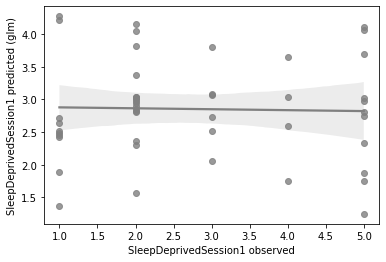

In [549]:
x = behav_obs_pred.filter(regex=("obs")).astype(float)
y = behav_obs_pred.filter(regex=('glm')).astype(float)

g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color='gray')

For the neg tail, 7 edges were selected in at least 70.0% of folds


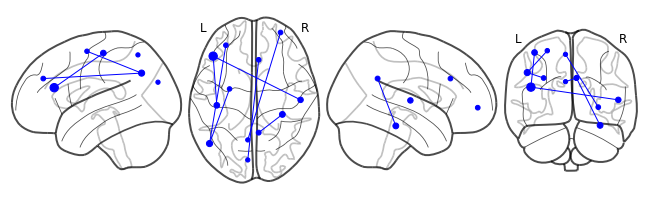

In [397]:
plot_consistent_edges(all_masks, "neg", thresh = 0.7, color = 'blue')
